## Installs and API

In [1]:
import os
os.environ["OPENAI_API_KEY"] =
OPENAI_API_KEY =

In [2]:
!pip install --upgrade httpx==0.28.1
!pip install langchain
!pip install langchain openai
!pip install langchain_community
!pip install langchain_core
!pip install langchain_experimental
!pip install langgraph
!pip install -U duckduckgo-search
!pip install deep-translator
!pip install openai
!pip install wikipedia
!pip install pandas numpy
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created w

## LangChain

In [3]:
# Import from LangChain
from langchain.tools import Tool, DuckDuckGoSearchResults
from langchain.llms import OpenAI
from langchain import PromptTemplate
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents import initialize_agent, AgentType
from langchain.chat_models import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from deep_translator import GoogleTranslator
from langchain.memory import ConversationBufferMemory
import wikipedia
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Tuple, Optional
import re
import nltk

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


### Pandas Analysis Tool Logic

In [4]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


# Generate sample data
n_rows = 1000

# Generate dates
start_date = datetime(2022, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(n_rows)]

# Define data categories
makes = ['Toyota', 'Honda', 'Ford', 'Chevrolet', 'Nissan', 'BMW', 'Mercedes', 'Audi', 'Hyundai', 'Kia']
models = ['Sedan', 'SUV', 'Truck', 'Hatchback', 'Coupe', 'Van']
colors = ['Red', 'Blue', 'Black', 'White', 'Silver', 'Gray', 'Green']

# Create the dataset
data = {
    'Date': dates,
    'Make': np.random.choice(makes, n_rows),
    'Model': np.random.choice(models, n_rows),
    'Color': np.random.choice(colors, n_rows),
    'Year': np.random.randint(2015, 2023, n_rows),
    'Price': np.random.uniform(20000, 80000, n_rows).round(2),
    'Mileage': np.random.uniform(0, 100000, n_rows).round(0),
    'EngineSize': np.random.choice([1.6, 2.0, 2.5, 3.0, 3.5, 4.0], n_rows),
    'FuelEfficiency': np.random.uniform(20, 40, n_rows).round(1),
    'SalesPerson': np.random.choice(['Alice', 'Bob', 'Charlie', 'David', 'Eva'], n_rows)
}

# Create DataFrame and sort by date
df = pd.DataFrame(data).sort_values('Date')

# Display sample data and statistics
print("\nFirst few rows of the generated data:")
print(df.head())

print("\nDataFrame info:")
df.info()

print("\nSummary statistics:")
print(df.describe())


First few rows of the generated data:
        Date      Make      Model  Color  Year     Price  Mileage  EngineSize  \
0 2022-01-01       Kia      Truck   Gray  2021  39656.81  14537.0         3.0   
1 2022-01-02  Mercedes  Hatchback   Blue  2015  78397.59  73902.0         1.6   
2 2022-01-03   Hyundai        SUV  White  2015  26609.94  76523.0         2.5   
3 2022-01-04  Mercedes  Hatchback    Red  2015  43140.21  20440.0         3.5   
4 2022-01-05    Toyota  Hatchback   Gray  2019  77396.61  74511.0         2.0   

   FuelEfficiency SalesPerson  
0            31.2     Charlie  
1            39.2         Eva  
2            25.7       David  
3            38.9       Alice  
4            30.9         Bob  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1000 non-null   datetime64[ns]
 1 

In [5]:
pandas_agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4", temperature=0, openai_api_key=OPENAI_API_KEY),
    df,
    verbose=True,
    allow_dangerous_code=True,  # Only set this if you're comfortable with code execution
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

<ipython-input-5-3ea9bb3d3ba5>:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  ChatOpenAI(model="gpt-4", temperature=0, openai_api_key=OPENAI_API_KEY),


### DuckDuckGo Logic

In [6]:
search = DuckDuckGoSearchResults()
class SummarizeText(BaseModel):
    """Model for text to be summarized."""
    text: str = Field(..., title="Text to summarize", description="The text to be summarized")

In [7]:
def parse_search_results(results_string: str) -> List[dict]:
    """Parse a string representation of search results into a list of dictionaries."""
    results = []
    entries = results_string.split(', snippet: ')
    for entry in entries[1:]:  # Skip the first split as it's empty
        parts = entry.split(', title: ')
        if len(parts) == 2:
            snippet = parts[0]
            title_link = parts[1].split(', link: ')
            if len(title_link) == 2:
                title, link = title_link
                results.append({
                    'snippet': snippet,
                    'title': title,
                    'link': link
                })
    return results

def perform_web_search(query: str, specific_site: Optional[str] = None) -> Tuple[List[str], List[Tuple[str, str]]]:
    """Perform a web search based on a query, optionally including a specific website."""
    try:
        if specific_site:
            specific_query = f"site:{specific_site} {query}"
            print(f"Searching for: {specific_query}")
            specific_results = search.run(specific_query)
            print(f"Specific search results: {specific_results}")
            specific_parsed = parse_search_results(specific_results)

            general_query = f"-site:{specific_site} {query}"
            print(f"Searching for: {general_query}")
            general_results = search.run(general_query)
            print(f"General search results: {general_results}")
            general_parsed = parse_search_results(general_results)

            combined_results = (specific_parsed + general_parsed)[:3]
        else:
            print(f"Searching for: {query}")
            web_results = search.run(query)
            print(f"Web results: {web_results}")
            combined_results = parse_search_results(web_results)[:3]

        web_knowledge = [result.get('snippet', '') for result in combined_results]
        sources = [(result.get('title', 'Untitled'), result.get('link', '')) for result in combined_results]

        print(f"Processed web_knowledge: {web_knowledge}")
        print(f"Processed sources: {sources}")
        return web_knowledge, sources
    except Exception as e:
        print(f"Error in perform_web_search: {str(e)}")
        import traceback
        traceback.print_exc()
        return [], []

def summarize_text(text: str, source: Tuple[str, str]) -> str:
    """Summarize the given text using OpenAI's language model."""
    try:
        # Instantiate your ChatOpenAI with a desired model and temperature.
        llm = ChatOpenAI(temperature=0.7, model="gpt-4o-mini",openai_api_key=OPENAI_API_KEY)
        prompt_template = "Please summarize the following text in a listed bullet point format:\n\n{text}\n\nSummary:"
        prompt = PromptTemplate(
            template=prompt_template,
            input_variables=["text"],
        )
        # Chain the prompt with the LLM (here we use a simple invocation)
        summary_chain = prompt | llm
        input_data = {"text": text}
        summary = summary_chain.invoke(input_data)

        # If the summary has a content attribute, use it; otherwise convert to string.
        summary_content = summary.content if hasattr(summary, 'content') else str(summary)
        formatted_summary = f"Source: {source[0]} ({source[1]})\n{summary_content.strip()}\n"
        return formatted_summary
    except Exception as e:
        print(f"Error in summarize_text: {str(e)}")
        return ""

def search_summarize(query: str, specific_site: Optional[str] = None) -> str:
    """Perform a web search and summarize the results."""
    web_knowledge, sources = perform_web_search(query, specific_site)

    if not web_knowledge or not sources:
        print("No web knowledge or sources found.")
        return ""

    # Create a list of summaries—only add non-empty summaries
    summaries = []
    for knowledge, source in zip(web_knowledge, sources):
        summary = summarize_text(knowledge, source)
        if summary:
            summaries.append(summary)

    combined_summary = "\n".join(summaries)
    return combined_summary

# -------------------------------------------------------------------
# Wrap the above `search_summarize` function as a LangChain Tool
# -------------------------------------------------------------------

duckduckgo_search_summarize_tool = Tool(
    name="DuckDuckGoSearchSummarize",
    func=search_summarize,
    description=(
        "Performs a web search using DuckDuckGo based on the input query "
        "and summarizes the top 3 search results using an OpenAI LLM. "
        "Optionally, you can restrict the search to a specific site by providing the 'specific_site' parameter."
    )
)




### Inital Tools Test and Output

In [8]:
# Calculator Tool (basic arithmetic)
def calculator_tool(expression: str) -> str:
    try:
        result = eval(expression)  # In production, consider a safer math parser.
        return f"The result of '{expression}' is {result}."
    except Exception as e:
        return f"Error evaluating expression '{expression}': {e}"

calculator = Tool(
    name="Calculator",
    func=calculator_tool,
    description="Evaluates simple mathematical expressions, e.g. '2+2'."
)

# Python Code Execution Tool
def code_execution_tool(code: str) -> str:
    """
    Executes Python code in a restricted environment.
    WARNING: Using exec can be a security risk. Use a sandbox in production.
    """
    import io
    import contextlib

    output_buffer = io.StringIO()
    try:
        with contextlib.redirect_stdout(output_buffer):
            exec(code, {"__builtins__": {}})
        return output_buffer.getvalue() or "Code executed successfully with no output."
    except Exception as e:
        return f"Error executing code: {str(e)}"

code_executor = Tool(
    name="CodeExecutor",
    func=code_execution_tool,
    description="Executes a snippet of Python code and returns its output. Use carefully!"
)

# Wikipedia Summary Tool
def wikipedia_tool(query: str) -> str:
    try:
        summary = wikipedia.summary(query, sentences=2)
        return summary
    except Exception as e:
        return f"Could not retrieve Wikipedia summary for '{query}': {str(e)}"

wikipedia_search = Tool(
    name="WikipediaSearch",
    func=wikipedia_tool,
    description="Looks up a summary of a topic using Wikipedia."
)

# Translation Tool (using deep-translator)
def translation_tool(text: str, target_language: str = "en") -> str:
    try:
        translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
        return f"Translated text: {translated_text}"
    except Exception as e:
        return f"Translation error: {str(e)}"

translator = Tool(
    name="Translator",
    func=translation_tool,
    description="Translates the given text into a specified language (default is English)."
)

# Sentiment Analysis Tool (simple keyword-based approach)
def sentiment_analysis_tool(text: str) -> str:
    lower_text = text.lower()
    if any(word in lower_text for word in ["happy", "excellent", "great", "good"]):
        return "Positive sentiment detected."
    elif any(word in lower_text for word in ["sad", "bad", "terrible", "awful"]):
        return "Negative sentiment detected."
    else:
        return "Neutral or no clear sentiment detected."

sentiment_analyzer = Tool(
    name="SentimentAnalysis",
    func=sentiment_analysis_tool,
    description="Analyzes the sentiment of a given text (positive, negative, or neutral)."
)


def pandas_analysis_tool(query: str) -> str:
    """
    This tool calls the Pandas DataFrame agent with a natural language query.
    Returns the agent's response as a string.
    """
    try:
        response = pandas_agent.run(query)
        return str(response)
    except Exception as e:
        return f"Error in Pandas DataFrame tool: {str(e)}"

pandas_tool = Tool(
    name="PandasDataAnalysis",
    func=pandas_analysis_tool,
    description=(
        "Use this tool to ask questions about the loaded Pandas DataFrame. "
        "For example, you can filter, describe statistics, or transform the data."
    )
)

duckduckgo_search_summarize_tool = Tool(
    name="DuckDuckGoSearchSummarize",
    func=search_summarize,
    description=(
        "Performs a web search using DuckDuckGo based on the input query "
        "and summarizes the top 3 search results using an OpenAI LLM. "
        "Optionally, you can restrict the search to a specific site by providing the 'specific_site' parameter."
    )
)

# --- 3. Combine Tools into a Single Agent -------------------------------------

tools = [
    calculator,
    code_executor,
    wikipedia_search,
    translator,
    sentiment_analyzer,
    pandas_tool,
    duckduckgo_search_summarize_tool
]

In [ ]:
# Initialize the OpenAI language model with your API key.
# Replace 'your_openai_api_key_here' with your actual API key.
llm = ChatOpenAI(model="gpt-4", temperature=0, openai_api_key=OPENAI_API_KEY)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Initialize the agent with the provided tool and language model.
agent = initialize_agent(
    tools=tools,
    llm=llm,
    allow_dangerous_code=True,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,  # ReAct agent
    verbose=True,  # see chain-of-thought reasoning
    memory=memory
)

In [ ]:
query = (
        """
        1) Calculate 3*7.
        2) Check a brief Wikipedia summary about 'Large language models'.
        3) Translate the summary to Spanish.
        4) Analyze if the text is positive or negative.
        5) Summarize it in 1 paragraph.
        6) Then show me a simulated web search on that topic.
        """
        )

print("USER QUERY:", query)
result = agent.run(query)
print("\nAGENT RESULT:\n", result)

USER QUERY: 
        1) Calculate 3*7.
        2) Check a brief Wikipedia summary about 'Large language models'.
        3) Translate the summary to Spanish.
        4) Analyze if the text is positive or negative.
        5) Summarize it in 1 paragraph.
        6) Then show me a simulated web search on that topic.
        


> Entering new AgentExecutor chain...
The question has multiple parts. I will start with the first part which is a simple mathematical calculation.
Action: Calculator
Action Input: '3*7'
Observation: The result of ''3*7'' is 3*7.
Thought:The first part of the question has been answered. Now, I will move on to the second part which requires a Wikipedia summary about 'Large language models'.
Action: WikipediaSearch
Action Input: 'Large language models'
Observation: A large language model (LLM) is a type of machine learning model designed for natural language processing tasks such as language generation. LLMs are language models with many parameters, and are trained w

In [ ]:

query = (
    """
    "Search online the benefits of renewable energy"
    """
)

print("USER QUERY:", query)
result = agent.run(query)
print("\nAGENT RESULT:\n", result)

USER QUERY: 
    "Search online the benefits of renewable energy"
    


> Entering new AgentExecutor chain...
I need to perform an online search to find information about the benefits of renewable energy.
    
Action: 
    DuckDuckGoSearchSummarize
    
Action Input: 
    "benefits of renewable energy" 
    Searching for: benefits of renewable energy" 

Web results: snippet: Some of the benefits of renewable energy hit headlines, others are well known. But some benefits aren't even primary benefits at all, and are happy by-products of other pursuits. So for this week's Top 10, we run through some of the benefits that renewable energy brings businesses, individuals, governments and countries, to name a few. 10., title: Top 10: Benefits of Renewable Energy | Energy Magazine - Energy Digital, link: https://energydigital.com/top10/top-10-benefits-of-renewable-energy, snippet: Purchasing renewable energy from an electric utility through a green pricing or green marketing program, where buy

### Tree Of Thought Simple Example

In [ ]:
#!/usr/bin/env python
import os
from typing import List
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.tools import Tool

# -------------------------------
# Reasoner Agent: Generate Multiple Reasoning Paths
# -------------------------------
def generate_reasoning_paths(query: str, num_paths: int = 3) -> List[str]:
    """
    Generates multiple distinct reasoning paths for a given query.
    Uses a Tree-of-Thought style prompt to have the LLM propose different paths.
    """
    llm = ChatOpenAI(temperature=0.7, model="gpt-4", openai_api_key=OPENAI_API_KEY)
    prompt_template = PromptTemplate(
        template=(
            "You are a reasoning agent. Given the following query: '{query}', "
            "generate {num_paths} distinct reasoning paths. "
            "For each path, include detailed chain-of-thought steps and a final answer. "
            "Format your response as follows:\n\n"
            "Path 1:\n<reasoning steps>\nAnswer: <final answer>\n\n"
            "Path 2:\n<reasoning steps>\nAnswer: <final answer>\n\n"
            "Path 3:\n<reasoning steps>\nAnswer: <final answer>\n\n"
            "Ensure each path is logically sound."
        ),
        input_variables=["query", "num_paths"]
    )
    prompt = prompt_template.format(query=query, num_paths=num_paths)
    response = llm.predict(prompt)
    # Assume the response is structured with "Path 1:" markers
    paths = []
    for segment in response.split("Path "):
        segment = segment.strip()
        if segment:
            # Prepend "Path " back to each segment for clarity
            paths.append("Path " + segment)
    return paths[:num_paths]

# -------------------------------
# Thought Validator Agent: Validate Reasoning
# -------------------------------
def validate_reasoning_path(reasoning: str) -> bool:
    """
    Validates a reasoning path using a dedicated prompt.
    Returns True if the reasoning is valid, or False otherwise.
    """
    llm = ChatOpenAI(temperature=0.5, model="gpt-4", openai_api_key=OPENAI_API_KEY)
    prompt_template = PromptTemplate(
        template=(
            "You are a Thought Validator. Evaluate the following reasoning chain "
            "and determine if it is logically sound, factually accurate, and complete.\n\n"
            "Reasoning:\n{reasoning}\n\n"
            "Respond with only 'Valid' if the reasoning is acceptable, or 'Invalid' if it is not, "
            "followed by a brief explanation."
        ),
        input_variables=["reasoning"]
    )
    prompt = prompt_template.format(reasoning=reasoning)
    validation_response = llm.predict(prompt)
    # If response starts with "Valid" (ignore case), then consider it valid
    if validation_response.strip().lower().startswith("valid"):
        return True
    else:
        return False

# -------------------------------
# Combined Multi-Agent ToT Reasoner with Thought Validator
# -------------------------------
def multi_agent_tot_reasoner(query: str) -> str:
    """
    Orchestrates the multi-agent Tree-of-Thought reasoning process:
      1. Generates multiple reasoning paths for the query.
      2. Validates each path.
      3. Selects a consensus (first valid) path.
      4. Returns a detailed output showing all reasoning paths along with their validation status,
         the chosen consensus path, and the final answer extracted from that path.
    """
    # Generate multiple reasoning paths
    paths = generate_reasoning_paths(query, num_paths=3)

    # Validate each path and record its status (True=Valid, False=Invalid)
    valid_flags = []
    for path in paths:
        is_valid = validate_reasoning_path(path)
        valid_flags.append(is_valid)

    # Select the first valid path; if none are valid, choose the first path as a fallback
    consensus_idx = None
    for i, valid in enumerate(valid_flags):
        if valid:
            consensus_idx = i
            break
    if consensus_idx is None:
        consensus_idx = 0  # Fallback if no path is valid

    consensus_path = paths[consensus_idx]

    # Extract the final answer from the consensus path
    # Look for a line that starts with "Answer:" (case-insensitive)
    final_answer = "No final answer found."
    for line in consensus_path.splitlines():
        if line.strip().lower().startswith("answer:"):
            final_answer = line.split("Answer:", 1)[1].strip()
            break

    # Build a string that includes all paths and marks each as VALID/INVALID
    all_paths_str = ""
    for i, (path, is_valid) in enumerate(zip(paths, valid_flags), start=1):
        status = "VALID" if is_valid else "INVALID"
        all_paths_str += f"--- Path {i} ({status}) ---\n{path}\n\n"

    result = (
        f"All Generated Reasoning Paths:\n{all_paths_str}"
        f"--- Consensus Path (Path {consensus_idx+1}) ---\n{consensus_path}\n\n"
        f"Final Answer: {final_answer}"
    )
    return result

# -------------------------------
# Wrap as a LangChain Tool
# -------------------------------
tot_reasoner_tool = Tool(
    name="MultiAgentToTReasoner",
    func=multi_agent_tot_reasoner,
    description=(
        "A multi-agent Tree-of-Thought reasoning tool with a Thought Validator. "
        "Generates multiple reasoning paths for a given query, validates them, "
        "and returns all paths (with their VALID/INVALID status), along with a consensus reasoning "
        "and the final answer extracted from it."
    )
)

In [ ]:
# -------------------------------
# Example Integration into a LangChain Agent
# -------------------------------
if __name__ == "__main__":
    # Set your API key here or use your environment configuration
    os.environ["OPENAI_API_KEY"] = ""

    # Example query for complex reasoning
    query = "How can I optimize a sorting algorithm in Python for large datasets?"
    answer = tot_reasoner_tool.func(query)
    print("Multi-Agent ToT Reasoner Tool Output:\n", answer)

Multi-Agent ToT Reasoner Tool Output:
 All Generated Reasoning Paths:
--- Path 1 (VALID) ---
Path 1:
1. The query is about optimizing a sorting algorithm in Python for large datasets. 
2. The first step to understand is what "optimization" means in this context. It generally refers to improving the efficiency of the algorithm - in terms of time or space complexity. 
3. The first way to do this is to choose an efficient sorting algorithm. The best sorting algorithm will depend on the specific circumstances, but quicksort, mergesort, and heapsort are all efficient general-purpose sorting algorithms.
4. However, since we are dealing with large datasets specifically, we need to consider memory usage as well as execution time. An algorithm like mergesort, which creates new lists during the sorting process, might not be optimal due to high memory usage.
5. The in-place version of quicksort could be a good option here, as it has a good average time complexity (O(n log n)) and doesn't use extr

### Memory Types Testing - Episodic

In [17]:
!pip install langchain_openai
!pip install langchain-community
!pip install langgraph

In [12]:
import os
from typing import Any, Dict, List

from langchain import LLMChain
from langchain.schema import BaseMemory
from langchain.memory import ConversationBufferMemory, CombinedMemory
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType, Tool
from langchain.embeddings.openai import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# --- Define your tools -----------------------------------------------------

# Calculator Tool (basic arithmetic)
def calculator_tool(expression: str) -> str:
    try:
        result = eval(expression)  # In production, consider a safer math parser.
        return f"The result of '{expression}' is {result}."
    except Exception as e:
        return f"Error evaluating expression '{expression}': {e}"

calculator = Tool(
    name="Calculator",
    func=calculator_tool,
    description="Evaluates simple mathematical expressions, e.g. '2+2'."
)

# Python Code Execution Tool
def code_execution_tool(code: str) -> str:
    """
    Executes Python code in a restricted environment.
    WARNING: Using exec can be a security risk. Use a sandbox in production.
    """
    import io
    import contextlib

    output_buffer = io.StringIO()
    try:
        with contextlib.redirect_stdout(output_buffer):
            exec(code, {"__builtins__": {}})
        return output_buffer.getvalue() or "Code executed successfully with no output."
    except Exception as e:
        return f"Error executing code: {str(e)}"

code_executor = Tool(
    name="CodeExecutor",
    func=code_execution_tool,
    description="Executes a snippet of Python code and returns its output. Use carefully!"
)

# Wikipedia Summary Tool
def wikipedia_tool(query: str) -> str:
    try:
        summary = wikipedia.summary(query, sentences=2)
        return summary
    except Exception as e:
        return f"Could not retrieve Wikipedia summary for '{query}': {str(e)}"

wikipedia_search = Tool(
    name="WikipediaSearch",
    func=wikipedia_tool,
    description="Looks up a summary of a topic using Wikipedia."
)

# Translation Tool (using deep-translator)
def translation_tool(text: str, target_language: str = "en") -> str:
    try:
        translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
        return f"Translated text: {translated_text}"
    except Exception as e:
        return f"Translation error: {str(e)}"

translator = Tool(
    name="Translator",
    func=translation_tool,
    description="Translates the given text into a specified language (default is English)."
)

# Sentiment Analysis Tool (simple keyword-based approach)
def sentiment_analysis_tool(text: str) -> str:
    lower_text = text.lower()
    if any(word in lower_text for word in ["happy", "excellent", "great", "good"]):
        return "Positive sentiment detected."
    elif any(word in lower_text for word in ["sad", "bad", "terrible", "awful"]):
        return "Negative sentiment detected."
    else:
        return "Neutral or no clear sentiment detected."

sentiment_analyzer = Tool(
    name="SentimentAnalysis",
    func=sentiment_analysis_tool,
    description="Analyzes the sentiment of a given text (positive, negative, or neutral)."
)


def pandas_analysis_tool(query: str) -> str:
    """
    This tool calls the Pandas DataFrame agent with a natural language query.
    Returns the agent's response as a string.
    """
    try:
        response = pandas_agent.run(query)
        return str(response)
    except Exception as e:
        return f"Error in Pandas DataFrame tool: {str(e)}"

pandas_tool = Tool(
    name="PandasDataAnalysis",
    func=pandas_analysis_tool,
    description=(
        "Use this tool to ask questions about the loaded Pandas DataFrame. "
        "For example, you can filter, describe statistics, or transform the data."
    )
)

duckduckgo_search_summarize_tool = Tool(
    name="DuckDuckGoSearchSummarize",
    func=search_summarize,
    description=(
        "Performs a web search using DuckDuckGo based on the input query "
        "and summarizes the top 3 search results using an OpenAI LLM. "
        "Optionally, you can restrict the search to a specific site by providing the 'specific_site' parameter."
    )
)

# --- Combine Tools into a Single Agent -------------------------------------

tools = [
    calculator,
    code_executor,
    wikipedia_search,
    translator,
    sentiment_analyzer,
    pandas_tool,
    duckduckgo_search_summarize_tool
]

# --- Long-term Memory & QA Cache Helpers -----------------------------------

_long_term_store: Dict[str, List[str]] = {}
_qa_cache: Dict[str, str] = {}
_qa_embeddings: Dict[str, List[float]] = {}

def update_long_term_memory(session_id: str, user_input: str, assistant_output: str) -> None:
    mem = _long_term_store.setdefault(session_id, [])
    if user_input:
        mem.append(f"User said: {user_input}")
    if assistant_output:
        mem.append(f"Assistant responded: {assistant_output}")
    _long_term_store[session_id] = mem[-10:]

def get_long_term_memory(session_id: str) -> str:
    return "\n".join(_long_term_store.get(session_id, []))

# setup embedding model
embeddings = OpenAIEmbeddings(
    openai_api_key=OPENAI_API_KEY)


# --- Implement LongTermChatMemory -----------------------------------------

class LongTermChatMemory(BaseMemory):
    session_id: str

    @property
    def memory_key(self) -> str:
        return "long_term_memory"

    @property
    def memory_variables(self) -> List[str]:
        return [self.memory_key]

    def load_memory_variables(self, inputs: Dict[str, Any]) -> Dict[str, str]:
        return {self.memory_key: get_long_term_memory(self.session_id)}

    def save_context(self, inputs: Dict[str, Any], outputs: Dict[str, Any]) -> None:
        update_long_term_memory(
            self.session_id,
            inputs.get("input", ""),
            outputs.get("output", ""),
        )

    def clear(self) -> None:
        _long_term_store[self.session_id] = []

# --- Build CombinedMemory for a single session -----------------------------

SESSION_ID = "user_123"
short_term = ConversationBufferMemory(
    memory_key="chat_history",
    input_key="input",
    return_messages=True,
)
long_term = LongTermChatMemory(session_id=SESSION_ID)
combined_memory = CombinedMemory(memories=[short_term, long_term])

# --- Pure Chat LLMChain setup ---------------------------------------------

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful AI assistant."),
    ("system", "Conversation so far:\n{chat_history}"),
    ("system", "Long‑term memory:\n{long_term_memory}"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}"),
])
llm = ChatOpenAI(
    model="gpt-4",
    temperature=0,
    openai_api_key=OPENAI_API_KEY
)
chat_chain = LLMChain(
    prompt=prompt,
    llm=llm,
    memory=combined_memory,
)

# --- Initialize the ReAct agent with memory -------------------------------

agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory=combined_memory,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
     handle_parsing_errors=True,  # allow agent to retry on parse failures
    verbose=True,
)

# --- Dispatcher & Semantic Cache ------------------------------------------

TOOL_KEYWORDS = [
    "calculate", "translate", "search", "list", "give me", "find",
    "what is", "what are", "who is", "summarize", "analyze",
]

SIMILARITY_THRESHOLD = 0.85

def is_tool_query(text: str) -> bool:
    low = text.strip().lower()
    for kw in TOOL_KEYWORDS:
        if low.startswith(kw):
            return True
    if ";" in text or "\n" in text:
        return True
    return False


def find_similar_cached(query: str) -> str:
    vec = np.array(embeddings.embed_query(query)).reshape(1, -1)
    for orig, orig_vec in _qa_embeddings.items():
        sim = cosine_similarity(vec, np.array(orig_vec).reshape(1, -1))[0][0]
        if sim >= SIMILARITY_THRESHOLD:
            return orig
    return None


def converse(user_input: str) -> str:
    low = user_input.lower().strip()
    # memory recall shortcut
    if "remember" in low or "previous" in low or "asked you" in low:
        memory = get_long_term_memory(SESSION_ID)
        return f"Here's what I remember:\n{memory}"

    if is_tool_query(user_input):
        # semantic cache lookup
        similar = find_similar_cached(user_input)
        if similar:
            return _qa_cache[similar]
        # run agent
        result = agent.run(user_input)
        # cache text and embedding
        _qa_cache[user_input] = result
        _qa_embeddings[user_input] = embeddings.embed_query(user_input)
        return result

    # fallback to pure chat
    return chat_chain.run(user_input)


In [13]:
# ————————————————————————————————
# 8) Example Usage
# ————————————————————————————————

print("AI:", converse("Do you remember our previous questions?"))
print("AGENT:", converse("Search and find me a list of the most popular foods in the world."))

AI: Here's what I remember:



> Entering new AgentExecutor chain...
I need to perform a web search to find a list of the most popular foods in the world.
Action: DuckDuckGoSearchSummarize
Action Input: Most popular foods in the worldSearching for: Most popular foods in the world
Web results: snippet: Discover the most rated dishes in the world, from pizza to kahvaltı, from picanha to guotie. Explore the ingredients, recipes, variations, and iconic restaurants of each dish., title: Top 100 Dishes in the World - TasteAtlas, link: https://www.tasteatlas.com/best-rated-dishes-in-the-world, snippet: What is the 10 most popular food in the world? The top 10 most eaten food in the world includes staples like rice, bread, and pasta. These foods are consumed globally and form the base of many diets. Additionally, dishes such as pizza, hamburgers, and sushi are also among the most popular food in the world due to their widespread appeal and ..., title: Top 10 Most Eaten Food In The World - magg

In [14]:
print("AGENT:", converse("Do you remember our previous questions?"))
print("AGENT:", converse("Search and find me a list of the most popular foods in the world."))

AGENT: Here's what I remember:
User said: Search and find me a list of the most popular foods in the world.
Assistant responded: The most popular foods in the world include staples like rice, bread, and pasta, and dishes like pizza, hamburgers, and sushi. However, the popularity of food can be influenced by cultural preferences, availability, and personal taste.
AGENT: The most popular foods in the world include staples like rice, bread, and pasta, and dishes like pizza, hamburgers, and sushi. However, the popularity of food can be influenced by cultural preferences, availability, and personal taste.


In [15]:
print("AGENT:", converse("What are the most popular foods you found?"))

AGENT: The most popular foods in the world include staples like rice, bread, and pasta, and dishes like pizza, hamburgers, and sushi. However, the popularity of food can be influenced by cultural preferences, availability, and personal taste.


In [21]:
!pip install langgraph

In [41]:
try:
    from langgraph.graph import Graph
    from IPython.display import Image, display
    from langchain_core.runnables.graph import MermaidDrawMethod

    # Create a simple Graph to illustrate memory lifecycle
    workflow = Graph()

    # Node functions operate on a shared state dict
    def load_memory(state: Dict[str, Any]) -> Dict[str, Any]:
        # Load from long-term store into state
        state['memory'] = get_long_term_memory(SESSION_ID).split("")
        return state

    def use_memory(state: Dict[str, Any]) -> Dict[str, Any]:
        # Placeholder: use memory in reasoning
        return state

    def save_memory(state: Dict[str, Any]) -> Dict[str, Any]:
        # Save any updates back to long-term store
        update_long_term_memory(SESSION_ID, state.get('input', ''), state.get('output', ''))
        return state

    # Add nodes and define workflow
    workflow.add_node('LoadMemory', load_memory)
    workflow.add_node('UseMemory', use_memory)
    workflow.add_node('SaveMemory', save_memory)

    # Set entry and finish points
    workflow.set_entry_point('LoadMemory')
    workflow.add_edge('LoadMemory', 'UseMemory')
    workflow.add_edge('UseMemory', 'SaveMemory')
    workflow.set_finish_point('SaveMemory')

    # Compile the workflow (optional)
    compiled = workflow.compile()
    # Print out the workflow nodes directly from the Graph instance
    print('Memory Workflow nodes:', workflow.nodes)

except Exception as e:
    print('LangGraph Graph unavailable:', e)


Memory Workflow nodes: {'LoadMemory': NodeSpec(runnable=LoadMemory(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, ends=()), 'UseMemory': NodeSpec(runnable=UseMemory(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, ends=()), 'SaveMemory': NodeSpec(runnable=SaveMemory(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, ends=())}


In [83]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

# Define the state schema (placeholder fields)
class AgentState(TypedDict):
    chat_history: List[Any]
    long_term_memory: str

# Initialize the StateGraph
graph_builder = StateGraph(state_schema=AgentState)

# 1) Add each tool as a ToolNode
for tool in tools:
    graph_builder.add_node(tool.name, ToolNode([tool]))

# 2) Add memory nodes (loading short- and long-term memory)
def load_short_term(state: AgentState) -> AgentState:
    state['chat_history'] = short_term.load_memory_variables({})['chat_history']
    return state

def load_long_term(state: AgentState) -> AgentState:
    state['long_term_memory'] = long_term.load_memory_variables({})['long_term_memory']
    return state

graph_builder.add_node('LoadShortTermMemory', load_short_term)
graph_builder.add_node('LoadLongTermMemory', load_long_term)

# 3) Add CombinedMemory node which merges both memories
def combine_memory(state: AgentState) -> AgentState:
    # This node symbolizes the CombinedMemory action
    return state

graph_builder.add_node('CombineMemory', combine_memory)

# 4) Add Agent Initialization node
def init_agent(state: AgentState) -> AgentState:
    # Placeholder: agent would be initialized with tools and memory here
    return state

graph_builder.add_node('AgentInit', init_agent)

# 5) Define the workflow edges
# Start -> load memories
graph_builder.add_edge(START, 'LoadShortTermMemory')
graph_builder.add_edge(START, 'LoadLongTermMemory')
# Memories -> combine
graph_builder.add_edge('LoadShortTermMemory', 'CombineMemory')
graph_builder.add_edge('LoadLongTermMemory', 'CombineMemory')
# Tools feed into agent init
for tool in tools:
    graph_builder.add_edge(tool.name, 'CombineMemory')
# CombinedMemory -> AgentInit
graph_builder.add_edge('CombineMemory', 'AgentInit')
# AgentInit -> End
graph_builder.add_edge('AgentInit', END)

compiled = graph_builder.compile(checkpointer=combined_memory)
graph = compiled.get_graph()

# Render using Mermaid draw method
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

try:
    # Render PNG via the API method
    png_bytes = graph.draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    )
    display(Image(png_bytes))
except Exception as e:
    # Fallback: output Mermaid text source
    mermaid_code = graph.draw_mermaid()
    print("Mermaid source fallback:", mermaid_code)
    print("Failed to render PNG:", e)



Mermaid source fallback: ---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	Calculator(Calculator)
	CodeExecutor(CodeExecutor)
	WikipediaSearch(WikipediaSearch)
	Translator(Translator)
	SentimentAnalysis(SentimentAnalysis)
	PandasDataAnalysis(PandasDataAnalysis)
	DuckDuckGoSearchSummarize(DuckDuckGoSearchSummarize)
	LoadShortTermMemory(LoadShortTermMemory)
	LoadLongTermMemory(LoadLongTermMemory)
	CombineMemory(CombineMemory)
	AgentInit(AgentInit)
	__end__([<p>__end__</p>]):::last
	AgentInit --> __end__;
	Calculator --> CombineMemory;
	CodeExecutor --> CombineMemory;
	CombineMemory --> AgentInit;
	DuckDuckGoSearchSummarize --> CombineMemory;
	LoadLongTermMemory --> CombineMemory;
	LoadShortTermMemory --> CombineMemory;
	PandasDataAnalysis --> CombineMemory;
	SentimentAnalysis --> CombineMemory;
	Translator --> CombineMemory;
	WikipediaSearch --> CombineMemory;
	__start__ --> LoadLongTermMemory;
	__start__ --> LoadShortTermMemory;
	classDef default fil

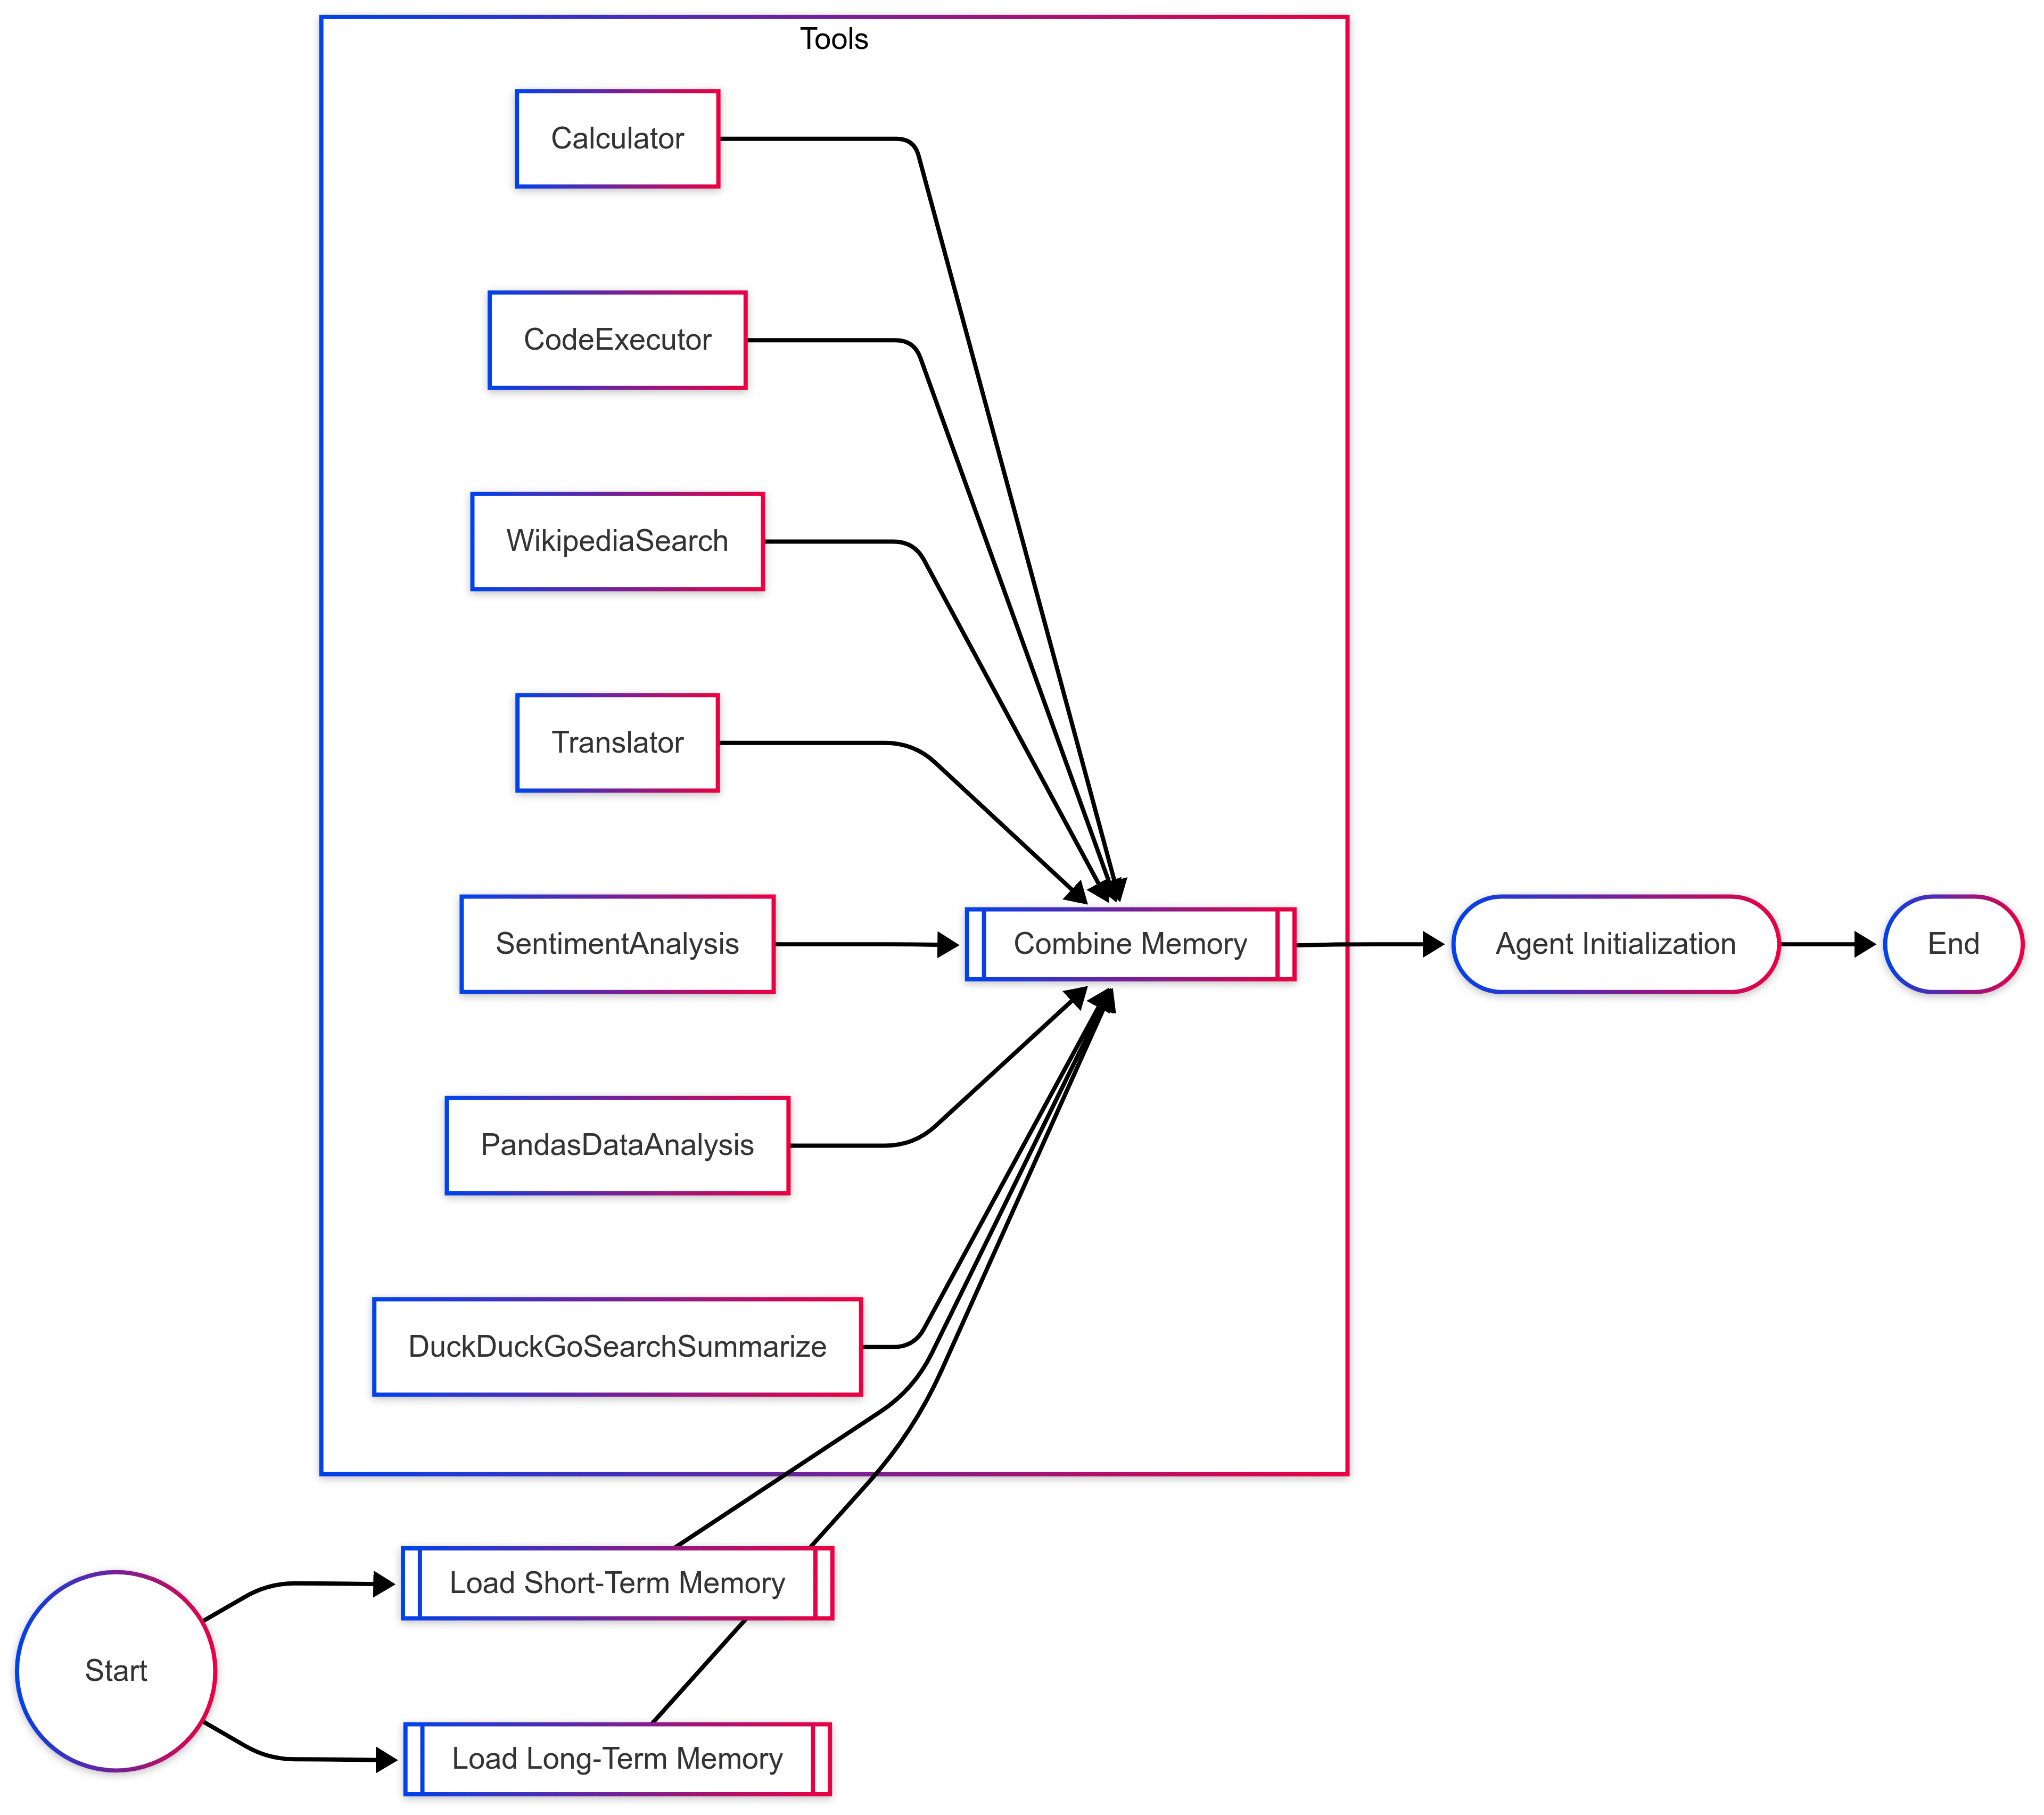

In [84]:
from IPython.display import Image
Image("/content/Mermaid_Memory_PNG.png")

## LlamaIndex

In [ ]:
!pip install llama-index gradio -qqq
!pip install llama-index-readers-file
!pip install langchain openai
# !pip install --upgrade llama-index langchain openai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-legacy 0.9.48.post4 requires requests>=2.31.0, but you have requests 2.29.0 which is incompatible.
llama-index-core 0.12.30 requires requests>=2.31.0, but you have requests 2.29.0 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.29.0 which is incompatible.
sphinx 8.2.3 requires requests>=2.30.0, but you have requests 2.29.0 which is incompatible.
yfinance 0.2.55 requires requests>=2.31, but you have requests 2.29.0 which is incompatible.
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.29.0
    Uninstalling requests-2.29.0:
      Successfully uninstalled requests-2.29.0
ERROR: pip's dependency resolver does not cu

In [ ]:
import os
import logging
import sys
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
    load_index_from_storage,
    Document,
    GPTVectorStoreIndex,
    readers
)

from llama_index.readers.file import (
    PDFReader,
    EpubReader,
    FlatReader,
    HTMLTagReader,
    ImageCaptionReader,
    ImageReader,
    ImageVisionLLMReader,
    IPYNBReader,
    MarkdownReader,
    MboxReader,
    PptxReader,
    PandasCSVReader,
    VideoAudioReader,
    UnstructuredReader,
    PyMuPDFReader,
    ImageTabularChartReader,
    XMLReader,
    PagedCSVReader,
    CSVReader,
    RTFReader,
)
import gradio as gr

ImportError: cannot import name 'VideoAudioParser' from 'llama_index.readers.file.video_audio' (/usr/local/lib/python3.11/dist-packages/llama_index/readers/file/video_audio/__init__.py)

In [ ]:
# Create some example documents.
documents = SimpleDirectoryReader("/content/TestingDocs").load_data()

# Build your index over the documents. This index will allow the agent to retrieve relevant document snippets.
index = GPTVectorStoreIndex(documents)

In [ ]:
# Initialize a ChatOpenAI instance; configure parameters like temperature as needed.
llm = ChatOpenAI(temperature=0.7)

# Create a conversation memory instance that will store the dialogue history.
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


def process_query(query: str):
    # Retrieve the previous conversation history from memory.
    history = memory.load_memory_variables({})
    # Format history into a string.
    conversation_context = ""
    for msg in history.get("chat_history", []):
        conversation_context += f"{msg['role'].capitalize()}: {msg['content']}\n"

    # Query the index for information relevant to the current query.
    index_response = index.query(query)

    # Combine previous conversation, the current query, and retrieved index information into a prompt.
    prompt = (
        f"{conversation_context}"
        f"User: {query}\n"
        f"Index information: {index_response}\n"
        f"Assistant:"
    )

    # Get the LLM to produce an answer based on the combined prompt.
    final_response = llm.predict(prompt)

    # Output the agent's response.
    print("Agent:", final_response)

    # Save the current interaction to the conversation memory for future context.
    memory.save_context({"input": query}, {"output": final_response})


# Run an Interactive Loop
# ------------------------------
print("Welcome! Type your queries (or 'exit' to quit):")
while True:
    user_input = input("Enter your query: ")
    if user_input.lower().strip() == "exit":
        break
    process_query(user_input)


## LangGraph

In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_openai import ChatOpenAI
from IPython.display import display, Markdown, Image

In [ ]:
!pip install langchain openai
!pip install pandas numpy nltk wikipedia deep_translator
!pip install langgraph langchain_experimental langchain_core langchain_openai
!pip install langchain langchain_community

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=e2ee1acf795025b915051ab061eab15b57f5124c3d7845f0530445771f6c3318
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [63]:
#!/usr/bin/env python
import os
from typing import List, Optional, TypedDict
from datetime import datetime
import pandas as pd
import numpy as np
import nltk
import wikipedia
from deep_translator import GoogleTranslator

# LangChain imports
from langchain.tools import Tool, DuckDuckGoSearchResults
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents import initialize_agent, AgentType
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory

# LangGraph imports
from langgraph.graph import StateGraph, START, END, Node
from typing_extensions import TypedDict as _TypedDict

# Ensure NLTK data is available
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# -------------------------------------------------------------------
# 1) DEFINE ALL YOUR TOOLS
# -------------------------------------------------------------------

# Calculator Tool
def calculator_tool(expr: str) -> str:
    try:
        return f"The result of '{expr}' is {eval(expr)}."
    except Exception as e:
        return f"Error evaluating expression '{expr}': {e}"

calculator = Tool(
    name="Calculator",
    func=calculator_tool,
    description="Evaluates simple math expressions, e.g. '2+2'."
)

# Code Execution Tool
def code_execution_tool(code: str) -> str:
    import io, contextlib
    buf = io.StringIO()
    try:
        with contextlib.redirect_stdout(buf):
            exec(code, {"__builtins__": {}})
        out = buf.getvalue().strip()
        return out or "Code executed with no output."
    except Exception as e:
        return f"Error executing code: {e}"

code_executor = Tool(
    name="CodeExecutor",
    func=code_execution_tool,
    description="Executes Python code snippets safely."
)

# Wikipedia Summary Tool
def wikipedia_tool(q: str) -> str:
    try:
        return wikipedia.summary(q, sentences=2)
    except Exception as e:
        return f"Wiki error: {e}"

wikipedia_search = Tool(
    name="WikipediaSearch",
    func=wikipedia_tool,
    description="Fetches a two-sentence summary from Wikipedia."
)

# Translation Tool
def translation_tool(text: str, target_language: str = "en") -> str:
    try:
        return GoogleTranslator(source="auto", target=target_language).translate(text)
    except Exception as e:
        return f"Translation error: {e}"

translator = Tool(
    name="Translator",
    func=translation_tool,
    description="Translates text into a specified language (default English)."
)

# Sentiment Analysis Tool
def sentiment_analysis_tool(text: str) -> str:
    t = text.lower()
    if any(w in t for w in ["happy", "good", "great"]):
        return "Positive sentiment"
    if any(w in t for w in ["sad", "bad", "terrible"]):
        return "Negative sentiment"
    return "Neutral sentiment"

sentiment_analyzer = Tool(
    name="SentimentAnalysis",
    func=sentiment_analysis_tool,
    description="Determines if text sentiment is positive, negative, or neutral."
)

# Placeholder DataFrame for the Pandas agent
df = pd.DataFrame({
    "Name": ["Alice", "Bob", "Charlie"],
    "Age": [25, 30, 35],
    "City": ["NY", "Paris", "London"]
})
pandas_agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    df,
    verbose=False,
    allow_dangerous_code=True,
    agent_type=AgentType.OPENAI_FUNCTIONS
)

def pandas_analysis_tool(q: str) -> str:
    try:
        return pandas_agent.run(q)
    except Exception as e:
        return f"Pandas tool error: {e}"

pandas_tool = Tool(
    name="PandasDataAnalysis",
    func=pandas_analysis_tool,
    description="Ask questions about the DataFrame, e.g. stats or filters."
)

# DuckDuckGo + Summarize Tool (simplified)
duck_tool = DuckDuckGoSearchResults()

def search_summarize(q: str, site: Optional[str] = None) -> str:
    # simple simulated summarization
    results = duck_tool.run(f"site:{site} {q}" if site else q)
    return "\n".join(results.split(",")[:3])

duck_summarize_tool = Tool(
    name="DuckDuckGoSearchSummarize",
    func=search_summarize,
    description="Searches the web and returns top 3 snippets."
)

# All tools list
TOOLS = [
    calculator,
    code_executor,
    wikipedia_search,
    translator,
    sentiment_analyzer,
    pandas_tool,
    duck_summarize_tool
]

# -------------------------------------------------------------------
# 2) MODEL ROUTING LOGIC
# -------------------------------------------------------------------
def route_model(query: str) -> str:
    """
    Simple router:
      - If query mentions 'code' or 'DataFrame' or is longer than 100 chars → gpt-4
      - Otherwise → gpt-3.5-turbo
    """
    if any(term in query.lower() for term in ["code", "dataframe", "pandas"]):
        return "gpt-4"
    if len(query) > 100:
        return "gpt-4"
    return "gpt-3.5-turbo"

# -------------------------------------------------------------------
# 3) DEFINE YOUR STATE FOR LANGGRAPH
# -------------------------------------------------------------------
class State(_TypedDict):
    query: str
    chosen_model: str
    llm: ChatOpenAI
    memory: ConversationBufferMemory
    agent: Any
    result: str

# -------------------------------------------------------------------
# 4) BUILD THE LANGGRAPH WORKFLOW
# -------------------------------------------------------------------
def build_workflow() -> StateGraph[State]:
    graph = StateGraph[State]("AgentWithRouting")

    # Start node: receive query
    def start(state: State) -> Partial[State]:
        return {}  # nothing to do; state["query"] is already set

    start_node = Node("Start", start, inputs=[START], outputs=[])

    # Router node: pick model
    def do_route(state: State) -> Partial[State]:
        state["chosen_model"] = route_model(state["query"])
        return {"chosen_model": state["chosen_model"]}

    router_node = Node("ModelRouter", do_route, inputs=["query"], outputs=["chosen_model"])

    # Instantiate LLM + Agent
    def instantiate(state: State) -> Partial[State]:
        model = state["chosen_model"]
        llm = ChatOpenAI(model=model, temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"))
        memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
        agent = initialize_agent(
            tools=TOOLS,
            llm=llm,
            memory=memory,
            allow_dangerous_code=True,
            agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
            verbose=False
        )
        return {"llm": llm, "memory": memory, "agent": agent}

    inst_node = Node(
        "InstantiateAgent",
        instantiate,
        inputs=["chosen_model"],
        outputs=["llm", "memory", "agent"]
    )

    # Run the agent
    def run_agent(state: State) -> Partial[State]:
        state["result"] = state["agent"].run(state["query"])
        return {"result": state["result"]}

    run_node = Node("RunAgent", run_agent, inputs=["agent", "query"], outputs=["result"])

    # End node
    def end(state: State) -> Partial[State]:
        return {}

    end_node = Node("End", end, inputs=["result"], outputs=[END])

    # Add nodes & edges
    graph.add_node(start_node)
    graph.add_node(router_node)
    graph.add_node(inst_node)
    graph.add_node(run_node)
    graph.add_node(end_node)

    graph.add_edge(start_node, router_node, from_output=None, to_input="query")
    graph.add_edge(router_node, inst_node, from_output="chosen_model", to_input="chosen_model")
    graph.add_edge(start_node, run_node, from_output=None, to_input="query")
    graph.add_edge(inst_node, run_node, from_output=["agent"], to_input="agent")
    graph.add_edge(run_node, end_node, from_output="result", to_input="result")

    graph.set_entry_point(start_node)
    graph.set_finish_point(end_node)

    return graph

# -------------------------------------------------------------------
# 5) MAIN: DEMONSTRATE THE WORKFLOW
# -------------------------------------------------------------------
if __name__ == "__main__":
    os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_API_KEY>"

    wf = build_workflow()
    # Print ASCII diagram of routing + agent flow
    print("\n=== Workflow Diagram ===\n")
    print(wf.ascii())

    # Run with a sample query
    sample_query = (
        "1) Calculate 3*7. 2) Give me a Wikipedia summary of 'Large language models'. "
        "3) Translate that summary to Spanish. 4) Check its sentiment. 5) Summarize in one paragraph. "
        "6) Also do a web search for best practices in using LLM agents."
    )
    final_state = wf.run({"query": sample_query})
    print("\n=== Agent Result ===\n")
    print(final_state["result"])


ImportError: cannot import name 'Node' from 'langgraph.graph' (/usr/local/lib/python3.11/dist-packages/langgraph/graph/__init__.py)